# 0.0. Imports

In [94]:
import pandas as pd
import numpy as np
import seaborn as sns
import scikitplot as skplt
import xgboost as xgb

from matplotlib    import pyplot as plt

from xgboost import XGBClassifier
from sklearn import preprocessing as pp
from sklearn import model_selection as ms
from sklearn import ensemble as en
from sklearn import neighbors as nh
from sklearn import linear_model as lm
from sklearn.ensemble      import RandomForestClassifier

## 0.1. Loading Data

In [4]:
df_raw = pd.read_csv( '/Users/thiago/Thiago/Data_Science/comunidade_ds/health_insurance/data/raw/train.csv' )

In [5]:
df_raw.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


## 0.2. Helper Functions

In [69]:
sns.set(rc={'figure.figsize':(17,10)}) # Aumenta o tamanho dos plots no seaborn

# 1.0. DATA DESCRIPTION

In [7]:
df1 = df_raw.copy()

## 1.1. Rename Columns

In [8]:
df1.columns

Index(['id', 'Gender', 'Age', 'Driving_License', 'Region_Code',
       'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage', 'Response'],
      dtype='object')

In [9]:
 cols_new = ['id', 'gender', 'age', 'driving_license', 'region_code',
       'previously_insured', 'vehicle_age', 'vehicle_damage', 'annual_premium',
       'policy_sales_channel', 'vintage', 'response']

df1.columns = cols_new

In [10]:
df1.columns

Index(['id', 'gender', 'age', 'driving_license', 'region_code',
       'previously_insured', 'vehicle_age', 'vehicle_damage', 'annual_premium',
       'policy_sales_channel', 'vintage', 'response'],
      dtype='object')

## 1.2. Data Dimensions

In [11]:
print( 'Number of rows:{}'.format( df1.shape[0]))
print( 'Number of columns:{}'.format( df1.shape[1]))

Number of rows:381109
Number of columns:12


## 1.3. Data Types

In [12]:
df1.dtypes

id                        int64
gender                   object
age                       int64
driving_license           int64
region_code             float64
previously_insured        int64
vehicle_age              object
vehicle_damage           object
annual_premium          float64
policy_sales_channel    float64
vintage                   int64
response                  int64
dtype: object

## 1.4. Check NA

In [13]:
df1.isna().sum()

id                      0
gender                  0
age                     0
driving_license         0
region_code             0
previously_insured      0
vehicle_age             0
vehicle_damage          0
annual_premium          0
policy_sales_channel    0
vintage                 0
response                0
dtype: int64

## 1.5. Descriptive Statistical

In [14]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( include=['int64', 'float64', 'datetime64[ns]'] )

In [15]:
# Central Tendency - Mean, Meadian
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# Concat
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = [ 'attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,1.0,381109.0,381108.0,190555.000000,190555.0,110016.691870,9.443274e-16,-1.200000
1,age,20.0,85.0,65.0,38.822584,36.0,15.511591,6.725390e-01,-0.565655
2,driving_license,0.0,1.0,1.0,0.997869,1.0,0.046109,-2.159518e+01,464.354302
3,region_code,0.0,52.0,52.0,26.388807,28.0,13.229871,-1.152664e-01,-0.867857
4,previously_insured,0.0,1.0,1.0,0.458210,0.0,0.498251,1.677471e-01,-1.971871
5,annual_premium,2630.0,540165.0,537535.0,30564.389581,31669.0,17213.132474,1.766087e+00,34.004569
6,policy_sales_channel,1.0,163.0,162.0,112.034295,133.0,54.203924,-9.000081e-01,-0.970810
7,vintage,10.0,299.0,289.0,154.347397,154.0,83.671194,3.029517e-03,-1.200688
8,response,0.0,1.0,1.0,0.122563,0.0,0.327935,2.301906e+00,3.298788


# 2.0. FEATURE ENGINEERING

In [16]:
df2 = df1.copy()

In [17]:
# vehicle age
df2['vehicle_age'] = df2['vehicle_age'].apply( lambda x: 'over_2_years' if x == '> 2 Years' else 'between_1_2_year' 
                                                                        if x == '1-2 Year' else 'below_1_year' )
# vehicle damage                                                                     
df2['vehicle_damage'] = df2['vehicle_damage'].apply( lambda x: 1 if x == 'Yes' else 0 )

In [18]:
df2.head(10)

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
0,1,Male,44,1,28.0,0,over_2_years,1,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,between_1_2_year,0,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,over_2_years,1,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,below_1_year,0,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,below_1_year,0,27496.0,152.0,39,0
5,6,Female,24,1,33.0,0,below_1_year,1,2630.0,160.0,176,0
6,7,Male,23,1,11.0,0,below_1_year,1,23367.0,152.0,249,0
7,8,Female,56,1,28.0,0,between_1_2_year,1,32031.0,26.0,72,1
8,9,Female,24,1,3.0,1,below_1_year,0,27619.0,152.0,28,0
9,10,Female,32,1,6.0,1,below_1_year,0,28771.0,152.0,80,0


# 3.0. FILTERING

In [19]:
df3 = df2.copy()

Como não detectamos variáveis muito fora dos possíveis padrões, não será inicialmente realizar uma filtragem
de variáveis.

# 4.0. EDA

In [20]:
df4 = df3.copy()

## 4.1. Univariate Analisys

In [21]:
df4.columns

Index(['id', 'gender', 'age', 'driving_license', 'region_code',
       'previously_insured', 'vehicle_age', 'vehicle_damage', 'annual_premium',
       'policy_sales_channel', 'vintage', 'response'],
      dtype='object')

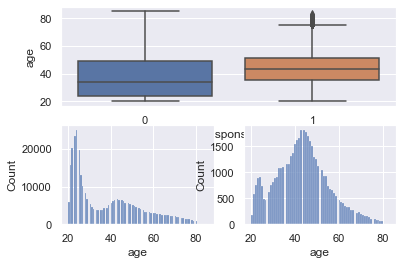

In [22]:
#age
plt.subplot( 2, 1, 1)
sns.boxplot( x='response', y='age', data=df4)

plt.subplot( 2, 2, 3)
aux00 = df4.loc[df4['response'] == 0, 'age']
sns.histplot( aux00 )

plt.subplot( 2, 2, 4)
aux00 = df4.loc[df4['response'] == 1, 'age']
sns.histplot( aux00 );

NameError: name 'aux' is not defined

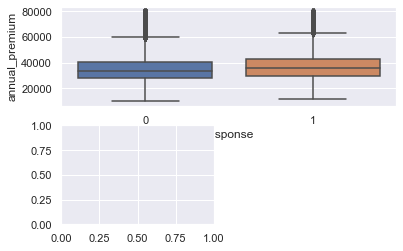

In [23]:
#annual_premium
aux0 = df4[ ( df4['annual_premium'] > 10000 ) & ( df4['annual_premium'] < 80000 ) ]
plt.subplot( 2, 1, 1)
sns.boxplot( x='response', y='annual_premium', data=aux0)

plt.subplot( 2, 2, 3)
aux1 = aux.loc[aux['response'] == 0, 'annual_premium']
sns.histplot( aux1 )

plt.subplot( 2, 2, 4)
aux2= aux.loc[aux['response'] == 1, 'annual_premium']
sns.histplot( aux2 );

In [24]:
#driving_license
aux = df4[['driving_license', 'response']].groupby( 'response' ).sum().reset_index()
aux.head()
aux['driving_license'] = aux['driving_license'] / aux['driving_license'].sum()
#sns.barplot( x='response', y='driving_license', data=aux);

In [25]:
aux

,response,driving_license
0,0,0.877283
1,1,0.122717


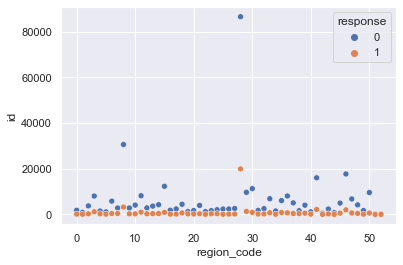

In [26]:
#region_code
aux = df4[['id', 'region_code', 'response']].groupby( ['region_code', 'response'] ).count().reset_index()
sns.scatterplot( x='region_code', y='id', hue='response', data=aux);

In [27]:
#gender

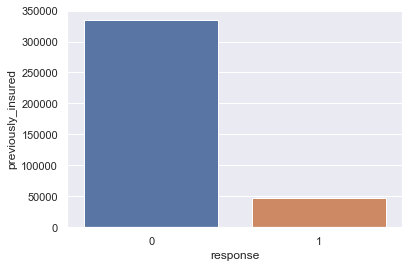

In [28]:
#previously_insured
aux = df4[['previously_insured', 'response']].groupby( 'response' ).count().reset_index()
aux
sns.barplot( x='response', y='previously_insured', data=aux);

In [29]:
pd.crosstab( df4['previously_insured'], df4['response'] )

response,0,1
previously_insured,,
0,159929,46552
1,174470,158


In [30]:
pd.crosstab( df4['previously_insured'], df4['response'] ).apply( lambda x: x / x.sum(), axis=1)

response,0,1
previously_insured,,
0,0.774546,0.225454
1,0.999095,0.000905


In [31]:
#vehicle_age
df4[['vehicle_age' ,'response']].value_counts( normalize=True ).reset_index()

,vehicle_age,response,0
0,between_1_2_year,0,0.434285
1,below_1_year,0,0.413488
2,between_1_2_year,1,0.091328
3,over_2_years,0,0.029663
4,below_1_year,1,0.018897
5,over_2_years,1,0.012338


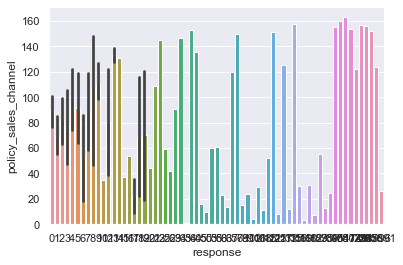

In [32]:
#policy_sales_channel
aux = df4[['policy_sales_channel', 'response']].groupby( 'policy_sales_channel').sum().reset_index()
sns.barplot( x='response', y='policy_sales_channel', data=aux); 

In [ ]:
df4.plot( x='response', kind='bar', stacked=True )
plt.show()


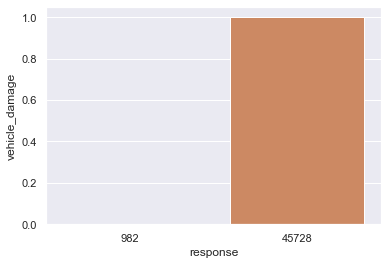

In [34]:
#vehicle_damage
aux = df4[['vehicle_damage', 'response']].groupby( 'vehicle_damage').sum().reset_index()
sns.barplot( x='response', y='vehicle_damage', data=aux); 

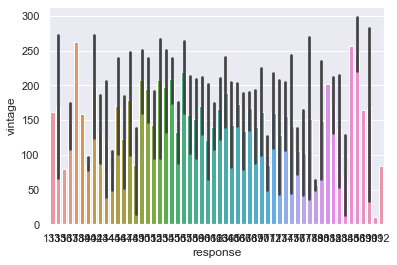

In [35]:
#vintage
aux = df4[['vintage', 'response']].groupby( 'vintage').sum().reset_index()
sns.barplot( x='response', y='vintage', data=aux); 

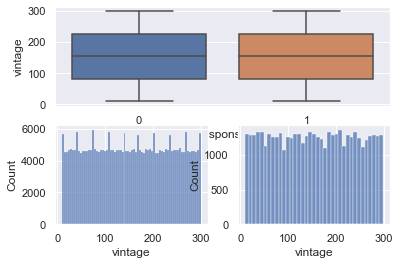

In [36]:
plt.subplot( 2, 1, 1)
sns.boxplot( x='response', y='vintage', data=df4)

plt.subplot( 2, 2, 3)
aux1 = df4.loc[df4['response'] == 0, 'vintage']
sns.histplot( aux1 )

plt.subplot( 2, 2, 4)
aux2= df4.loc[df4['response'] == 1, 'vintage']
sns.histplot( aux2 );

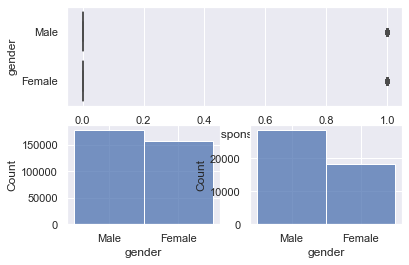

In [37]:
#gender
plt.subplot( 2, 1, 1)
sns.boxplot( x='response', y='gender', data=df4)

plt.subplot( 2, 2, 3)
aux1 = df4.loc[df4['response'] == 0, 'gender']
sns.histplot( aux1 )

plt.subplot( 2, 2, 4)
aux2= df4.loc[df4['response'] == 1, 'gender']
sns.histplot( aux2 );

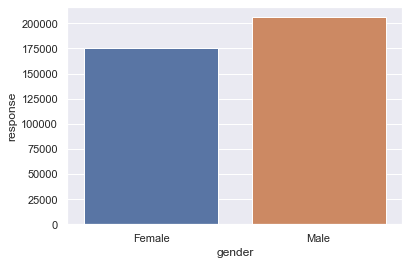

In [38]:
aux = df4[['gender', 'response']].groupby('gender').count().reset_index()
sns.barplot( x='gender', y='response', data=aux); 

# 5.0. DATA PREPARATION

In [52]:
df5 = df4.copy()

### Data  Split Train / Teste

In [53]:
X = df4.drop( 'response', axis=1 )
y = df4['response'].copy()

x_train, x_val, y_train, y_val = ms.train_test_split( X, y, test_size=0.20 )

df5 = pd.concat( [x_train, y_train], axis=1 )

## Standardization

In [54]:
ss = pp.StandardScaler()

# annual_premium|
df5['annual_premium'] = ss.fit_transform( df5[['annual_premium']].values ) # dois colchetes pois é necessário um array para o correto funciomanento dos Encoders

## Rescaling

In [55]:
mms_age = pp.MinMaxScaler()
mms_vintage= pp.MinMaxScaler()

# age
df5['age'] = mms_age.fit_transform( df5[['age']].values )

# vintage
df5['vintage'] = mms_vintage.fit_transform( df5[['vintage']].values )

## Encoder

In [56]:
df5['region_code'].unique() # alto número de variáveis, não recomendado usar o One Hot Encoding, pois vai complicar demais e requer uma quantidade maior de dados

array([ 8., 41., 37., 11., 15.,  6., 28., 47., 26., 45., 21., 24., 50.,
        9., 46., 29., 18., 14., 35., 33., 38.,  3., 30., 17.,  5., 36.,
       19., 13., 27., 20., 34., 39.,  7., 48., 43., 40.,  1., 16., 25.,
       31., 12., 49.,  4., 22., 23., 32., 44.,  2., 52., 42., 10., 51.,
        0.])

In [57]:
# driving_license / vehicle_damage / driving_license - Ja estão 0 e 1 ( Label Encoding )

# gender
target_encode_gender = df5.groupby( 'gender' )['response'].mean()
df5.loc[:, 'gender'] = df5['gender'].map( target_encode_gender )

# region_code - Frequency Encoding / Target Encoding / Weight Target Encoding
target_encode_region_code = df5.groupby( 'region_code' )['response'].mean()
df5.loc[:, 'region_code'] = df5['region_code'].map( target_encode_region_code )

# vehicle_age - One Hot Encoding / Order Encoding / Frequency Encoding
df5 = pd.get_dummies( df5, prefix='vehicle_age', columns=['vehicle_age'] )

# policy_sales_channel - Target Encoding / Frequency Encoding
fe_policy_sales_channel = df5.groupby( 'policy_sales_channel' ).size() / len( df5 )
df5.loc[:, 'policy_sales_channel'] = df5['policy_sales_channel'].map( fe_policy_sales_channel )

## 5.4 Validation Preparation

In [58]:
x_val.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage
231415,231416,Female,43,1,9.0,0,between_1_2_year,1,2630.0,160.0,232
220799,220800,Female,25,1,39.0,1,below_1_year,0,35495.0,152.0,174
315968,315969,Female,59,1,47.0,0,between_1_2_year,1,39998.0,26.0,257
85328,85329,Female,50,1,28.0,0,over_2_years,1,42530.0,26.0,204
206583,206584,Male,25,1,15.0,0,below_1_year,1,34776.0,152.0,189


In [59]:
# gender
x_val.loc[:, 'gender'] = x_val.loc[:, 'gender'].map( target_encode_gender )

# age
x_val.loc[:, 'age'] = mms_age.transform( x_val[['age']].values )

# region code
x_val.loc[:, 'region_code'] = x_val.loc[:, 'region_code'].map( target_encode_region_code )

# vehicle age
x_val = pd.get_dummies( x_val, prefix='vehicle_age', columns=['vehicle_age'] )

# annual premium
x_val.loc[:, 'annual_premium'] = ss.transform( x_val[['annual_premium']].values )

# policy sales channel
x_val.loc[:, 'policy_sales_channel'] = x_val['policy_sales_channel'].map( fe_policy_sales_channel )

# vintage
x_val.loc[:, 'vintage'] = mms_vintage.transform( x_val[['vintage']].values )

# fillna
x_val = x_val.fillna( 0 )

# 6.0. FEATURE SELECTION

## 6.2 Features Importance

In [60]:
# model definition
forest = en.ExtraTreesClassifier( n_estimators=250, random_state=0, n_jobs=-1 )

# data preaparation
x_train_n = df5.drop( ['id', 'response'], axis=1 )
y_train_n = y_train.values
forest.fit( x_train_n, y_train_n )

ExtraTreesClassifier(n_estimators=250, n_jobs=-1, random_state=0)

Feature ranking:
                        feature  importance
0                       vintage    0.272724
0                annual_premium    0.245040
0                           age    0.164820
0                   region_code    0.104167
0                vehicle_damage    0.067427
0          policy_sales_channel    0.061309
0            previously_insured    0.056591
0      vehicle_age_below_1_year    0.013967
0  vehicle_age_between_1_2_year    0.006073
0                        gender    0.004962
0      vehicle_age_over_2_years    0.002459
0               driving_license    0.000463


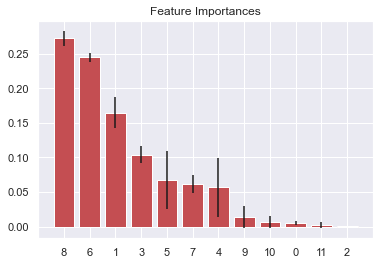

In [61]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0 )
indices = np.argsort(importances)[::-1]

# Print the Feature Ranking
print("Feature ranking:")
df = pd.DataFrame()
for i, j in zip( x_train_n, forest.feature_importances_ ):
    aux = pd.DataFrame( {'feature': i, 'importance': j}, index=[0] )
    df = pd.concat( [ df, aux], axis=0 )

print( df.sort_values( 'importance', ascending=False ) )

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title( "Feature Importances" )
plt.bar(range(x_train_n.shape[1]), importances[indices], color="r", yerr=std[indices], align="center" )
plt.xticks(range(x_train_n.shape[1]), indices)
plt.xlim([-1, x_train_n.shape[1]])
plt.show()

# 7.0. MACHINE LEARNING MODELLING

In [62]:
cols_selected = ['annual_premium', 'vintage', 'age', 'region_code', 'vehicle_damage', 'previously_insured', 'policy_sales_channel']

x_train = df5[ cols_selected ]
x_val = x_val[ cols_selected ]


## 7.1. KNN

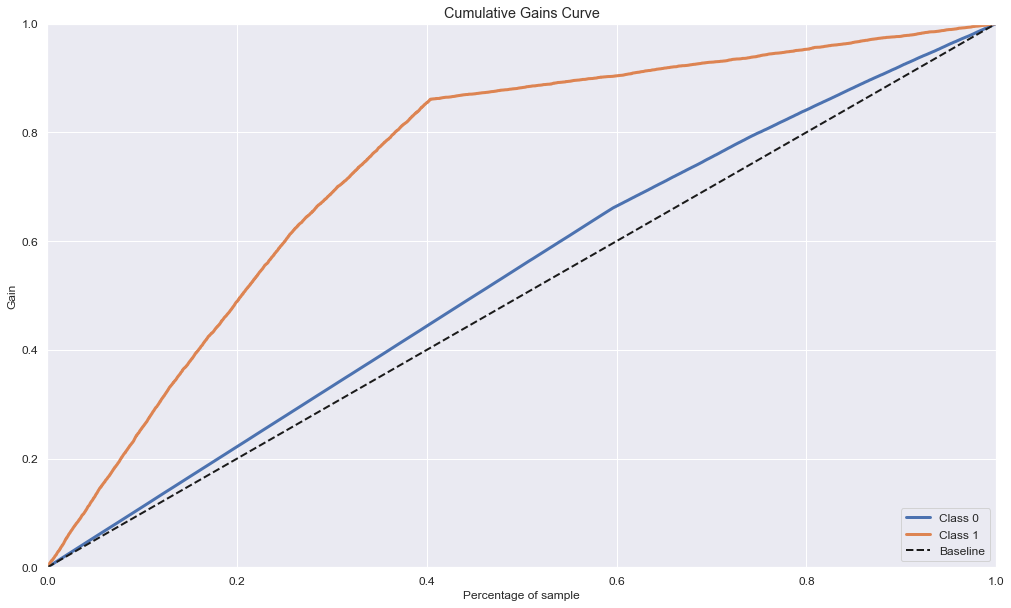

In [79]:
# model definition
knn_model = nh.KNeighborsClassifier( n_neighbors=7 )

# model training
knn_model.fit( x_train, y_train )

# model prediction - Generalization Power
yhat_knn = knn_model.predict_proba( x_val )
# Acummulative Gain
skplt.metrics.plot_cumulative_gain( y_val, yhat_knn);

## 7.2. Logistic Regression

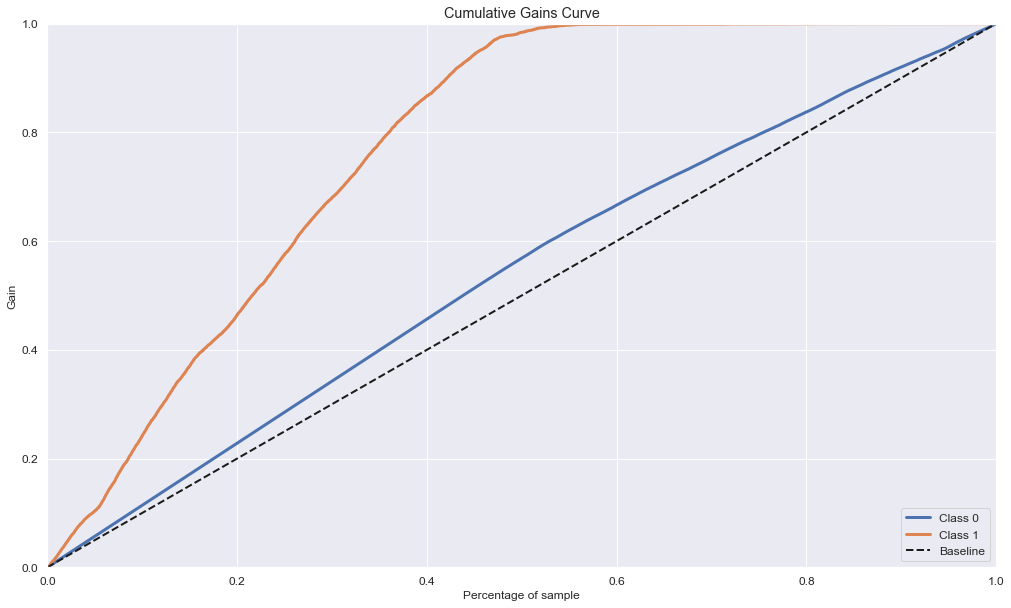

In [76]:
# model definition
lr_model = lm.LogisticRegression( random_state=42 )

# model training
lr_model.fit( x_train, y_train )

# model_prediction
yhat_lr = lr_model.predict_proba( x_val )

# Accumulative Gain
skplt.metrics.plot_cumulative_gain( y_val, yhat_lr);

## 7.3. Random Forest Classifier

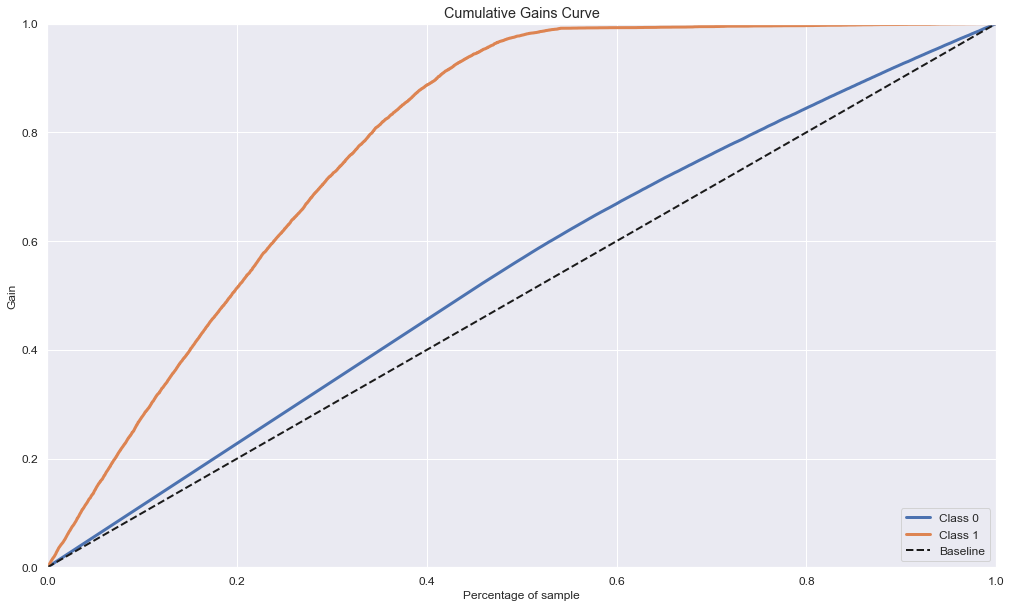

In [85]:
# model
rf_model = RandomForestClassifier( n_estimators=100, n_jobs=-1, random_state=42 ).fit( x_train, y_train )

# model training
rf_model.fit( x_train, y_train )

# model_prediction
yhat_rf = rf_model.predict_proba( x_val )

# Accumulative Gain
skplt.metrics.plot_cumulative_gain( y_val, yhat_rf);

## 7.4. XGBoost Classifier

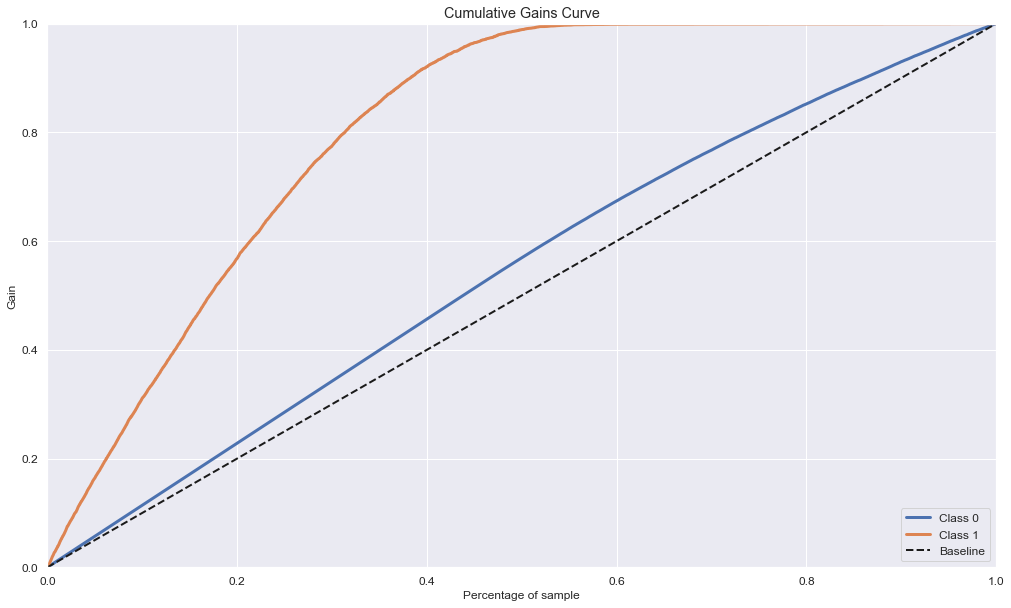

In [96]:
# model
xgb_model = XGBClassifier( max_depth= 4, n_estimators=100 ).fit( x_train, y_train )

# model training
xgb_model.fit( x_train, y_train )

# model_prediction
yhat_xgb = xgb_model.predict_proba( x_val )

# Accumulative Gain
skplt.metrics.plot_cumulative_gain( y_val, yhat_xgb);

## 7.6. Compare Model's Performance

### 7.6.1. Single Performance

### 7.6.1. Real Performance - Cross Validation

# 8.0. HYPERPARAMETER FINE TUNING

## 8.1. Random Search

## 8.2. Final Model

# 9.0. TRADUÇÃO E INTERPRETAÇÃO DO ERRO

## 9.1. Business Performance

## 9.2. Total Performance

## 9.3. Machine Learning Performance

# 10.0. DEPLOY MODEL TO PRODUCTION

## 10.1. Rossmann Class

## 10.2. API Handler

## 10.3. API Tester